# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 60% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [18]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [20]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.998409456070386
Mean of train-time output:  10.035823818740294
Mean of test-time output:  9.998409456070386
Fraction of train-time output set to zero:  0.698676
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.998409456070386
Mean of train-time output:  10.0098090794753
Mean of test-time output:  9.998409456070386
Fraction of train-time output set to zero:  0.39934
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.998409456070386
Mean of train-time output:  9.998545304541455
Mean of test-time output:  9.998409456070386
Fraction of train-time output set to zero:  0.24998
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [21]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445611489946063e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [22]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0
Initial loss:  2.3051948273987857
W1 relative error: 2.5272575351926774e-07
W2 relative error: 1.5034484932141387e-05
W3 relative error: 2.753446846744471e-07
b1 relative error: 2.9369574464090924e-06
b2 relative error: 5.051339805546953e-08
b3 relative error: 1.1740467838205477e-10


Running check with dropout =  0.25
We use dropout with p =0.250000
Initial loss:  2.305430205844589
W1 relative error: 1.6686928667201412e-10
W2 relative error: 2.4296802337407786e-09
W3 relative error: 2.9105684989372686e-08
b1 relative error: 3.842100120375669e-10
b2 relative error: 1.0680724254581638e-10
b3 relative error: 1.890088903300699e-10


Running check with dropout =  0.5
We use dropout with p =0.500000
Initial loss:  2.3075515207998
W1 relative error: 2.009949367982776e-08
W2 relative error: 7.873415366966094e-09
W3 relative error: 7.760189494567356e-08
b1 relative error: 3.0502544310515637e-09
b2 relative error: 6.50728700305734e-10
b3 relative error: 1.0035940

## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [23]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

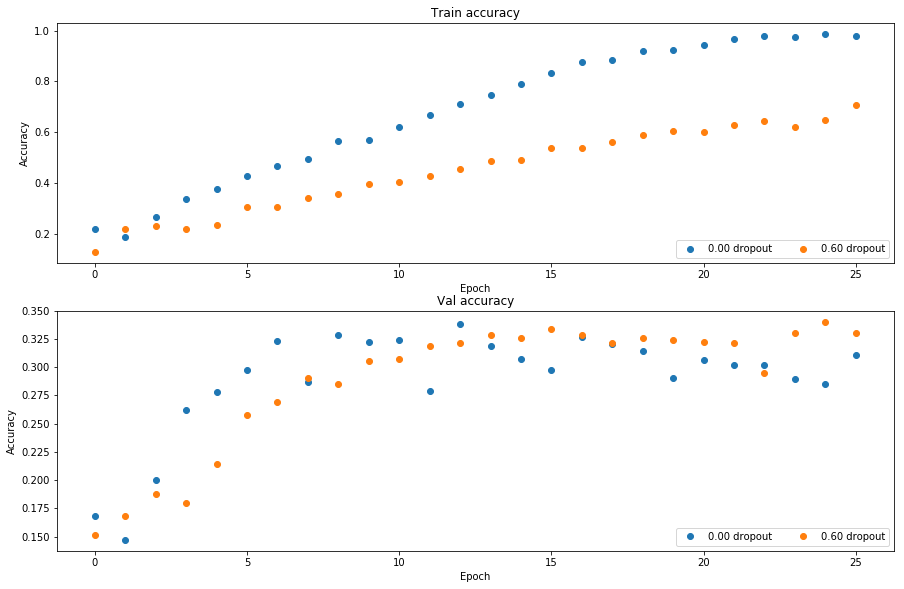

In [24]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Yes, effactively reduce the overfitting in the training

## Final part of the assignment

Get over 60% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 28%, 1) 
where if you get 60% or higher validation accuracy, you get full points.

In [57]:
optimizer = 'rmsprop'

layer_dims = [600, 600, 600, 600]
# weight_scale = 0.01
learning_rate = 1e-3
lr_decay = 0.95


model = FullyConnectedNet(layer_dims, 
                          weight_scale = 0.001,
                          dropout = 0.7, 
                          reg = 0.0,
                          use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=80, batch_size=100,
                update_rule=optimizer,
                optim_config={
                  'learning_rate': learning_rate,
                },
                lr_decay=lr_decay,
                verbose=True, print_every=100)

solver.train()




We use dropout with p =0.700000
(Iteration 1 / 39200) loss: 2.306706
(Epoch 0 / 80) train acc: 0.101000; val_acc: 0.119000
(Iteration 101 / 39200) loss: 1.614438
(Iteration 201 / 39200) loss: 1.811795
(Iteration 301 / 39200) loss: 1.685031
(Iteration 401 / 39200) loss: 1.653256
(Epoch 1 / 80) train acc: 0.474000; val_acc: 0.471000
(Iteration 501 / 39200) loss: 1.427879
(Iteration 601 / 39200) loss: 1.660352
(Iteration 701 / 39200) loss: 1.415424
(Iteration 801 / 39200) loss: 1.423672
(Iteration 901 / 39200) loss: 1.553335
(Epoch 2 / 80) train acc: 0.488000; val_acc: 0.498000
(Iteration 1001 / 39200) loss: 1.287287
(Iteration 1101 / 39200) loss: 1.582098
(Iteration 1201 / 39200) loss: 1.351826
(Iteration 1301 / 39200) loss: 1.393482
(Iteration 1401 / 39200) loss: 1.470090
(Epoch 3 / 80) train acc: 0.527000; val_acc: 0.519000
(Iteration 1501 / 39200) loss: 1.496470
(Iteration 1601 / 39200) loss: 1.482061
(Iteration 1701 / 39200) loss: 1.462378
(Iteration 1801 / 39200) loss: 1.427315
(Ite

(Iteration 15801 / 39200) loss: 0.778706
(Iteration 15901 / 39200) loss: 0.846725
(Iteration 16001 / 39200) loss: 0.728751
(Iteration 16101 / 39200) loss: 0.773865
(Epoch 33 / 80) train acc: 0.822000; val_acc: 0.601000
(Iteration 16201 / 39200) loss: 0.790856
(Iteration 16301 / 39200) loss: 0.773171
(Iteration 16401 / 39200) loss: 0.997188
(Iteration 16501 / 39200) loss: 0.821428
(Iteration 16601 / 39200) loss: 0.858699
(Epoch 34 / 80) train acc: 0.813000; val_acc: 0.597000
(Iteration 16701 / 39200) loss: 0.783970
(Iteration 16801 / 39200) loss: 0.765402
(Iteration 16901 / 39200) loss: 0.906179
(Iteration 17001 / 39200) loss: 0.807383
(Iteration 17101 / 39200) loss: 0.626653
(Epoch 35 / 80) train acc: 0.811000; val_acc: 0.605000
(Iteration 17201 / 39200) loss: 1.058272
(Iteration 17301 / 39200) loss: 0.707660
(Iteration 17401 / 39200) loss: 0.741119
(Iteration 17501 / 39200) loss: 0.809757
(Iteration 17601 / 39200) loss: 0.823079
(Epoch 36 / 80) train acc: 0.816000; val_acc: 0.599000
(

(Iteration 31501 / 39200) loss: 0.660990
(Iteration 31601 / 39200) loss: 0.954866
(Iteration 31701 / 39200) loss: 0.755050
(Iteration 31801 / 39200) loss: 0.802741
(Epoch 65 / 80) train acc: 0.868000; val_acc: 0.605000
(Iteration 31901 / 39200) loss: 0.734937
(Iteration 32001 / 39200) loss: 0.537741
(Iteration 32101 / 39200) loss: 0.809666
(Iteration 32201 / 39200) loss: 0.493336
(Iteration 32301 / 39200) loss: 0.562953
(Epoch 66 / 80) train acc: 0.871000; val_acc: 0.605000
(Iteration 32401 / 39200) loss: 0.702823
(Iteration 32501 / 39200) loss: 0.672728
(Iteration 32601 / 39200) loss: 0.594476
(Iteration 32701 / 39200) loss: 0.838080
(Iteration 32801 / 39200) loss: 0.608528
(Epoch 67 / 80) train acc: 0.876000; val_acc: 0.605000
(Iteration 32901 / 39200) loss: 0.813157
(Iteration 33001 / 39200) loss: 0.692915
(Iteration 33101 / 39200) loss: 0.779337
(Iteration 33201 / 39200) loss: 0.695039
(Iteration 33301 / 39200) loss: 0.648490
(Epoch 68 / 80) train acc: 0.901000; val_acc: 0.609000
(

In [58]:
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))

Validation set accuracy: 0.609
Test set accuracy: 0.622
